# ETF Portfolio Optimisation
This module:
- processes historical performance of hand-picked ETFs from Yahoo Finance,
- unifies the data by converting it to Polish Zloty,
- assess the expected return and volatility of the current portfolio,
- optimises an ETF portfolio using the PyPortfolioOpt (`pypfopt`) package.

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [15]:
START_DATE = date(2001, 1, 1)
END_DATE = date(2023, 12, 31)

Data gets downloaded manually from the Yahoo! Finance's API with the help of `yfinance`` package. There is data for both the ETF ratings in their issue currency as well as for the exchange rates. The exchange rate that everything will be recalculated into is Polish Zloty (PLN).

In [16]:
def download_from_yahoo_finance(tickers, start=START_DATE, end=END_DATE):
    yahoo_finance_data = yf.download(
        tickers=tickers,
        start=start,
        end=end,
    )["Adj Close"]

    return yahoo_finance_data

In [17]:
etf_df = download_from_yahoo_finance(
    tickers=[
        "AEEM.PA",
        "PHPM.L",
        "SGLN.L",
        "SPYD.DE",
        "STNX.SW",
        "SWDA.L",
        "XDWH.L",
    ]
)

exchange_rates_df = download_from_yahoo_finance(
    tickers=[
        "CHFPLN=X",
        "GBPPLN=X",
        "EURPLN=X",
        "PLN=X",
    ]
)

[*********************100%%**********************]  7 of 7 completed
[*********************100%%**********************]  4 of 4 completed


[Text(0.5, 1.0, 'Exchange rates to PLN'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price of currency in PLN')]

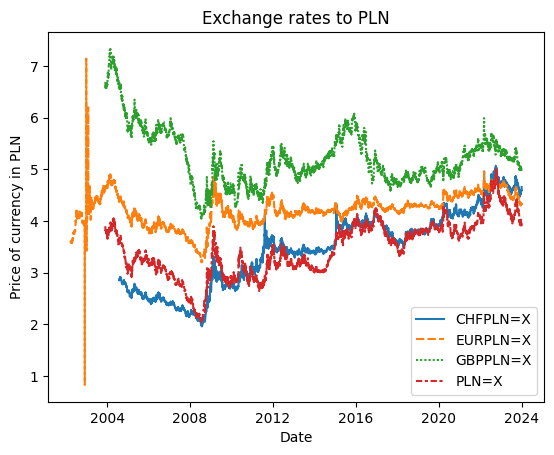

In [18]:
plot = sns.lineplot(data=exchange_rates_df)
plot.set(
    title="Exchange rates to PLN", xlabel="Date", ylabel="Price of currency in PLN"
)

There is something weird going on with the EUR to PLN plot around 2002-2003, but let's ignore this for now. This period will fall out of the analysis anyways.

Keep in mind that the weirdly labeled `PLN=X` item stands for the USD to PLN exchange rate. The name comes from the label on the Yahoo Finance website.

This is not very useful just yet. Let's bring all values to PLN first. Note that Yahoo Finance presents some ETF's values in fractions. These need to be included as well.

In [19]:
etf_currencies = {
    "SGLN.L": ["GBPPLN=X", 0.01],
    "STNX.SW": ["CHFPLN=X", 1],
    "SWDA.L": ["GBPPLN=X", 0.01],
    "PHPM.L": ["PLN=X", 1],
    "SPYD.DE": ["EURPLN=X", 1],
    "AEEM.PA": ["EURPLN=X", 1],
    "XDWH.L": ["PLN=X", 1],
}

for column_name in etf_df.columns:
    etf_df[column_name] = (
        etf_df[column_name]
        * exchange_rates_df[etf_currencies[column_name][0]]
        * etf_currencies[column_name][1]
    )

Now, let's remove rows where the data is not full, so that all series start from the same point in time.

In [20]:
etf_df.dropna(inplace=True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, though, let's write down the latest prices.

In [21]:
latest_prices = get_latest_prices(etf_df)
latest_prices

AEEM.PA     19.312559
PHPM.L     531.388795
SGLN.L     157.648662
SPYD.DE    268.609600
STNX.SW    851.654022
SWDA.L     353.650358
XDWH.L     196.607601
Name: 2023-12-27 00:00:00, dtype: float64

A function to normalize asset prices to start at the same value:

In [22]:
def normalize(df, start_value=100):
    return df.div(df.iloc[0] / start_value)

In [23]:
etf_df = normalize(etf_df)
etf_df

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
Date,,,,,,,
2011-10-14,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2011-10-17,101.492401,99.424853,100.311246,99.948783,100.326438,99.247754,97.428797
2011-10-18,101.746172,99.193805,100.218237,101.354840,102.080534,100.849052,100.172828
2011-10-19,101.491449,99.778432,99.487019,100.938813,103.302875,101.127192,100.044204
2011-10-20,99.486982,96.689165,97.927459,100.452842,101.673720,100.003302,99.699630
...,...,...,...,...,...,...,...
2023-12-19,174.191891,131.018146,150.099767,336.656123,264.982832,423.119014,482.700757
2023-12-20,173.110768,129.984313,150.335517,337.132610,267.040327,427.411295,480.644411
2023-12-21,174.491320,131.194788,151.242779,335.259601,265.856533,425.562056,484.009873


[Text(0.5, 1.0, 'Portfolio components history in normalized prices'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Relative value in PLN')]

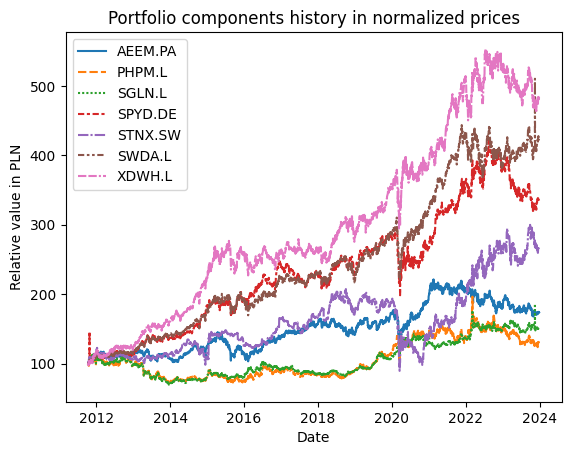

In [24]:
plot = sns.lineplot(data=etf_df)
plot.set(
    title="Portfolio components history in normalized prices",
    xlabel="Date",
    ylabel="Relative value in PLN",
)

## Evaluation of selected portfolio

Now it's time for the portfolio evaluation. We need to calculate expected yearly returns and the annualized covariance matrix.

In [25]:
mean_historical_returns = expected_returns.mean_historical_return(etf_df)
mean_historical_returns

AEEM.PA    0.048170
PHPM.L     0.022935
SGLN.L     0.036046
SPYD.DE    0.108517
STNX.SW    0.087249
SWDA.L     0.130936
XDWH.L     0.143857
dtype: float64

In [26]:
covariance_matrix = risk_models.sample_cov(etf_df)
covariance_matrix

,AEEM.PA,PHPM.L,SGLN.L,SPYD.DE,STNX.SW,SWDA.L,XDWH.L
AEEM.PA,0.034825,0.010345,0.001960,0.020812,0.019192,0.019256,0.016048
PHPM.L,0.010345,0.047676,0.027093,0.008523,0.016619,0.010447,0.017110
SGLN.L,0.001960,0.027093,0.041106,0.001420,0.004897,0.017887,0.005793
SPYD.DE,0.020812,0.008523,0.001420,0.055098,0.021008,0.023310,0.020616
STNX.SW,0.019192,0.016619,0.004897,0.021008,0.070486,0.017895,0.017411
SWDA.L,0.019256,0.010447,0.017887,0.023310,0.017895,0.038160,0.021368
XDWH.L,0.016048,0.017110,0.005793,0.020616,0.017411,0.021368,0.032786


Let's assign weights to the ETFs based on my current allocation.

In [27]:
current_weights = np.array([0, 0, 0, 0.4, 0, 0.1, 0.5])

Now we calculate the variance and the volatility (standard deviation) of the specified portfolio.

In [28]:
def assess_portfolio(weights, expected_returns, covariance_matrix):
    expected_portfolio_return = np.sum(expected_returns * weights)
    expected_portfolio_volatility = np.sqrt(weights.T @ covariance_matrix @ weights)

    return [expected_portfolio_return, expected_portfolio_volatility]


print(
    "Expected annual return: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0]
    )
)
print(
    "Expected annual volatility: {:.2%}".format(
        assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1]
    )
)

Expected annual return: 12.84%
Expected annual volatility: 17.22%


## Portfolio optimisation

Optimize for max Sharpe ratio

In [17]:
ef = EfficientFrontier(mean_historical_returns, covariance_matrix)
optimal_weights = ef.max_sharpe()
cleaned_optimal_weights = ef.clean_weights()
print(cleaned_optimal_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('AEEM.PA', 0.0), ('PHPM.L', 0.0), ('SGLN.L', 0.0), ('SPYD.DE', 0.0), ('STNX.SW', 0.0), ('SWDA.L', 0.29017), ('XDWH.L', 0.70983)])
Expected annual return: 13.8%
Annual volatility: 16.9%
Sharpe Ratio: 0.70


(0.137795979824064, 0.16919121016629127, 0.6962299028908596)

Get the discrete allocation of each share per stock

In [18]:
da = DiscreteAllocation(
    cleaned_optimal_weights, latest_prices, total_portfolio_value=50000
)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation:", allocation)
print("Funds Remaining: {:.2f} zł".format(leftover))

Discrete Allocation: {'AEEM.PA': 1, 'SWDA.L': 42, 'XDWH.L': 187}
Funds Remaining: 12.65 zł


Let's generate a random portfolio (i.e. a vector of non-negative numbers which sum up to one). For the details of how the function works, please see discussion in the [other notebook](random_portfolio_generator.ipynb).

In [19]:
def generate_random_weights(num_components):
    random_uniform = np.random.rand(num_components)
    random_exponential = np.log(random_uniform)
    return random_exponential / np.sum(random_exponential)

In [20]:
def generate_and_evaluate_random_portfolios(
    num_portfolios, expected_returns, covariance_matrix
):
    results = np.zeros((num_portfolios, 2))

    for i in range(num_portfolios):
        random_weights = generate_random_weights(covariance_matrix.shape[0])
        results[i, 0], results[i, 1] = assess_portfolio(
            random_weights, expected_returns, covariance_matrix
        )

    results = pd.DataFrame(results)
    results.columns = ["Annualised return", "Annualised volatility"]

    return results

In [21]:
portfolio_evaluations = generate_and_evaluate_random_portfolios(
    100_000, mean_historical_returns, covariance_matrix
)

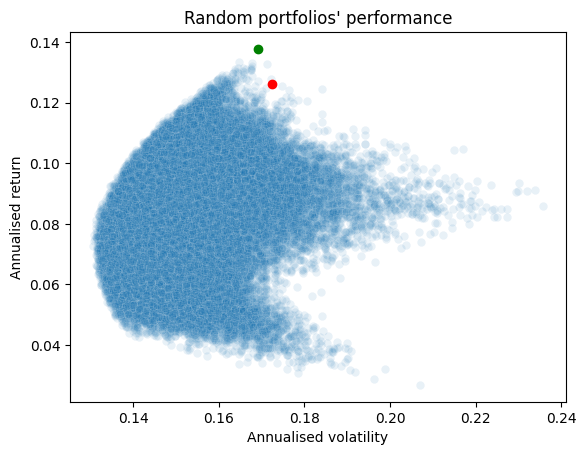

In [22]:
random_portfolios_plot = sns.scatterplot(
    data=pd.DataFrame(portfolio_evaluations),
    alpha=0.1,
    x="Annualised volatility",
    y="Annualised return",
)

random_portfolios_plot.set(title="Random portfolios' performance")

plt.scatter(
    x=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[1],
    y=assess_portfolio(current_weights, mean_historical_returns, covariance_matrix)[0],
    color="r",
)

plt.scatter(x=ef.portfolio_performance()[1], y=ef.portfolio_performance()[0], color="g")